# Information

In this exercise we will computationally determine the area of the Mandelbrot set. 

**NOTE: This notebook does not contain the data for the actual simulations (i.e. 100 STANDARD_NUM_RUNS per datapoint). The actual simulations took 3+ hours and the data stored in the .npy files "....".**

ALL IMPORTS HERE:

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import colorsys
from scipy.stats import norm
import matplotlib.patches as patches

ALL GLOBAL CONSTANTS HERE:

In [32]:
# Default ranges which we will test samples in
STANDARD_REAL_MIN = -2
STANDARD_REAL_MAX = 1
STANDARD_IMAGINARY_MIN = -1.5
STANDARD_IMAGINARY_MAX = 1.5
# Default ranges of samples and iterations we will perform simulations for
STANDARD_NUM_SAMPLES_MIN = 500
STANDARD_NUM_SAMPLES_MAX = 5000
STANDARD_NUM_SAMPLES_STEPS = 25
STANDARD_NUM_ITERATIONS_MIN = 50
STANDARD_NUM_ITERATIONS_MAX = 1000
STANDARD_NUM_ITERATIONS_STEPS = 15
# The amount of runs we execute for all simulations to calculate the variance
STANDARD_NUM_RUNS = 25
# The default number of iterations after which a point is regarded to be in the Mandelbrot set
STANDARD_MAX_ITERATIONS = 1000

In [26]:
class ComplexRange:
    """Datatype that stores an interval of complex numbers."""

    def __init__(
        self,
        real_min: float = STANDARD_REAL_MIN,
        real_max: float = STANDARD_REAL_MAX,
        imaginary_min: float = STANDARD_IMAGINARY_MIN,
        imaginary_max: float = STANDARD_IMAGINARY_MAX,
    ):
        self.real_min = real_min
        self.real_max = real_max
        self.imaginary_min = imaginary_min
        self.imaginary_max = imaginary_max

    def domain_area(self) -> float:
        """Calculate the area spanned by the complex numbers interval."""
        return (self.real_max - self.real_min) * (self.imaginary_max - self.imaginary_min)

The following code can optionally be run to load in the large calculations stored in the .npy files. These variables can be used to recreate the plots we used in the report. The rest of the file assumes these have not been loaded, and new simulations (of smaller sizes) have been run.

The large simulations were created with 100 runs each. The rest of the parameters can be derived from the code below.

In [4]:
areas_rs_loaded = np.load("MC.npy")
areas_lhs_loaded = np.load("LHS.npy")
areas_orth_loaded = np.load("Orthogonal.npy")

num_samples_rs_loaded = np.linspace(100, 10000, num=50, dtype=int)
num_iterations_rs_loaded = np.linspace(50, 1000, num=50, dtype=int)

num_samples_lhs_loaded = np.linspace(100, 10000, num=50, dtype=int)
num_iterations_lhs_loaded = np.linspace(50, 1000, num=50, dtype=int)

grid_size_orth_loaded = np.linspace(10, 100, num=50, dtype=int)
num_iterations_orth_loaded = np.linspace(50, 1000, num=50, dtype=int)

### (i) Visualizing the Mandelbrot set

In [6]:
def mandelbrot_sequence(
    complex_number: complex, max_iteration: int = STANDARD_MAX_ITERATIONS
) -> int:
    """Iterates a complex number with the Mandelbrot map z_{n+1} = z_n^2 + c
    for at most max_iterations iterations.

    Args:
        complex_number: The number being tested whether it is in the Mandelbrot set.
        max_iteration: The maximum amount of iterations for which the function will check a point.

    Returns:
        The last iteration counter if the complex number diverges else max_iteration.
    """
    z = 0
    counter = 0

    # The point diverges if it is ever greater than 2
    while np.abs(z) <= 2 and counter < max_iteration:
        counter += 1
        z = z**2 + complex_number
    return counter


def mandelbrot_diverges(
    complex_numbers: np.ndarray[complex], max_iteration: int = STANDARD_MAX_ITERATIONS
) -> np.ndarray[bool]:
    """Does the same thing as mandelbrot_sequence, but performs it for an array of values.
    This function is faster, but does not return info about how fast a point diverges.

    Args:
        complex_numbers: The numbers being tested whether they are in the Mandelbrot set.
        max_iteration: The maximum amount of iterations for which the function will check a point.

    Returns:
        Boolean array where True indicates that the corresponding point diverges.
    """
    z = np.zeros(complex_numbers.shape, dtype=np.complex128)

    diverged = np.zeros(complex_numbers.shape, dtype=bool)

    for _ in range(max_iteration):
        # Mandelbrot iterate points that haven't diverged yet
        z[~diverged] = z[~diverged] ** 2 + complex_numbers[~diverged]

        # Check for divergence and update the diverged array
        diverged |= np.abs(z) > 2

        # Stop if all points have diverged
        if np.all(diverged):
            break

    return diverged

### Plotting the Mandelbrot fractal with a colour gradient following a powerlaw. [Inspired by source.]

Computing Mandelbrot: 100%|██████████| 1000/1000 [00:57<00:00, 17.47it/s]


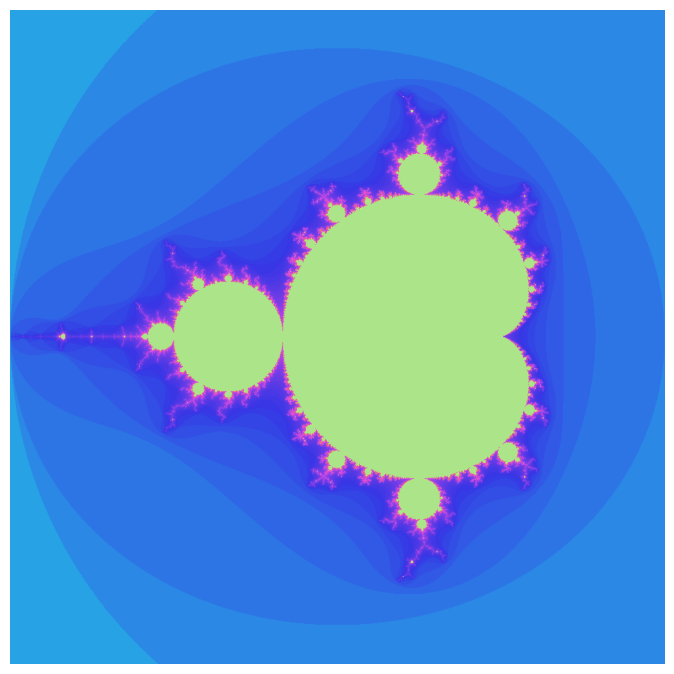

In [96]:
def power_color(
    distance: float, exp: float = 0.2, const: float = 0.27, scale: float = 1.0
) -> tuple[int]:
    """Map a normalized distance value to an RGB color using HSV color space.
    Inspired by https://medium.com/swlh/visualizing-the-mandelbrot-set-using-python-50-lines-f6aa5a05cf0f.

    Args:
        distance: Normalized distance (0 to 1).
        exp: Exponent to adjust the color scaling.
        const: Hue offset constant.
        scale: Hue scaling factor.

    Returns:
        tuple: RGB color tuple in the range 0-255.
    """
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color, 1 - 0.6 * color, 0.9)
    return tuple(int(i * 255) for i in rgb)


def plot_mandelbrot_fractal(
    complex_range: ComplexRange,
    width: int,
    height: int,
    max_iterations: int = STANDARD_MAX_ITERATIONS,
) -> None:
    """Generate and plot a Mandelbrot fractal, where the rate of divergence
    is indicated using a colour scaling law.

    Args:
        complex_range: Range of complex numbers to plot the image for.
        width: Width of the image in pixels.
        height: Height of the image in pixels.
        max_iterations: Maximum number of iterations to iterate a point for.
    """
    real_range = np.linspace(complex_range.real_min, complex_range.real_max, width)
    imaginary_range = np.linspace(complex_range.imaginary_min, complex_range.imaginary_max, height)

    # Create an empty array to store RGB values
    fractal_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Compute the fractal
    for real_idx, real in enumerate(tqdm.tqdm(real_range, desc="Computing Mandelbrot")):
        for imaginary_idx, imaginary in enumerate(imaginary_range):
            complex_number = complex(real, imaginary)
            last_iteration_number = mandelbrot_sequence(complex_number, max_iterations)
            # map the number of iterations to a value between 0 and 1
            distance = (last_iteration_number + 1) / (max_iterations + 1)

            fractal_image[imaginary_idx, real_idx] = power_color(distance)

    # Show the image without axes or margins
    plt.figure(figsize=(10, 8.5), frameon=False)
    plt.imshow(
        fractal_image,
       extent=[
            complex_range.real_min,
            complex_range.real_max,
            complex_range.imaginary_min,
            complex_range.imaginary_max,
        ], 
    )
    plt.axis("off")
    plt.show()
    


plot_mandelbrot_fractal(ComplexRange(), 1000, 850)

### (ii) Finding the area using Monte-Carlo:

In [27]:
def mandelbrot_area(
    complex_numbers: np.ndarray[complex], num_iteration: int, domain_area: float
) -> float:
    """Calculates the area of the Mandelbrot set by iterating a set of complex numbers a certain
    amount of times and calculating the amount of the numbers that diverge compared to the total
    number of points tested.

    Args:
        complex_numbers: The numbers being tested whether they are in the Mandelbrot set.
        num_iteration: Number of iterations to be executed on every complex number.
        domain_area: Area of the box where the points in complex_values are sampled from.

    Returns:
        The estimated area of the Mandelbrot set.
    """
    diverged = mandelbrot_diverges(complex_numbers, num_iteration)
    # The amount of points that belong to the Mandelbrot set
    number_bounded_points = np.count_nonzero(~diverged)

    mandelbrot_area = domain_area * number_bounded_points / np.shape(complex_numbers)[0]

    return mandelbrot_area

In [33]:
def mandelbrot_area_RS(
    complex_range: ComplexRange,
    num_samples: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using Monte Carlo integration and random sampling.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_samples: The list of number of samples for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(num_samples), len(num_iterations), runs))

    for sample_idx, num_sample in enumerate(tqdm.tqdm(num_samples, desc="Sample Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                # Generate random samples
                real_parts = np.random.uniform(
                    complex_range.real_min, complex_range.real_max, num_sample
                )
                imag_parts = np.random.uniform(
                    complex_range.imaginary_min, complex_range.imaginary_max, num_sample
                )
                complex_values = real_parts + 1j * imag_parts

                domain_area = complex_range.domain_area()

                areas[sample_idx, it_idx, run] = mandelbrot_area(
                    complex_values, num_iteration, domain_area
                )

    return areas


samples_range_rs = np.linspace(
    STANDARD_NUM_SAMPLES_MIN, STANDARD_NUM_SAMPLES_MAX, num=STANDARD_NUM_SAMPLES_STEPS, dtype=int
)
iterations_range_rs = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_rs = mandelbrot_area_RS(ComplexRange(), samples_range_rs, iterations_range_rs)

Sample Range Progress: 100%|██████████| 25/25 [02:40<00:00,  6.40s/it]


The mean area of the Mandelbrot set when calculated with 5000 random samples
when iterated 1000 times is 1.5229968000000003.


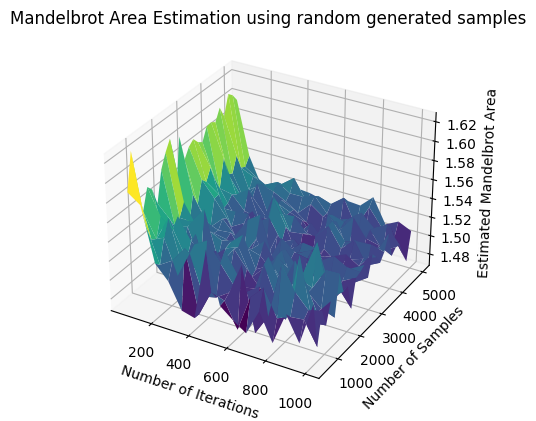

In [40]:
def plot_area_3d(
    areas: np.ndarray[float],
    samples_range: np.ndarray[int],
    iterations_range: np.ndarray[int],
    plot_title: str,
):
    """Plot the calculated areas of the Mandelbrot set as a function of amount of samples and iterations.

    Args:
        areas: The 3D array containing all the areas indexed by the samples and iterations.
        samples_range: The range of samples used to perform the calculations.
        iterations_range: The range of iterations used to perform the calculations.
        plot_title: Title of the plot that will be generated.
    """
    X, Y = np.meshgrid(iterations_range, samples_range)
    # Take the average over all the runs
    Z = np.mean(areas, axis=2)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis")

    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Number of Samples")
    ax.set_zlabel("Estimated Mandelbrot Area")

    plt.title(plot_title)
    plt.show()

print(
    f"The mean area of the Mandelbrot set when calculated with {samples_range_rs[-1]} random samples\n"
    f"when iterated {iterations_range_rs[-1]} times is {np.mean(areas_rs[-1])}."
)

plot_title_rs = "Mandelbrot Area Estimation using random generated samples"
plot_area_3d(areas_rs, samples_range_rs, iterations_range_rs, plot_title_rs)

### Latin Hypercube sampling

In [35]:
def lhs_samples(complex_range: ComplexRange, num_sample: int) -> np.ndarray[complex]:
    """Generate Latin Hypercube Sampling (LHS) points in a complex range.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_sample: The number of samples to generate.

    Returns:
        An array of complex numbers sampled using the LHS method.
    """

    def lhs_1d(min_val: float, max_val: float, num_sample: int) -> np.ndarray[float]:
        """Generate Latin Hypercube Sampling (LHS) points in one dimension. Essentially, multiple
        bins are created withing the value range. In each of these bins, a single random sample
        is generated.

        Args:
            min_val: The minimum value of the range.
            max_val: The maximum value of the range.
            num_sample: The number of samples to generate.

        Returns:
            An array of points sampled with LHS within the range.
        """
        # Create 'bins' on the [0,1] interval
        intervals = np.linspace(0, 1, num_sample + 1)

        # Compute random samples in each bin
        random_offsets = np.random.uniform(size=num_sample)
        normed_samples = intervals[:-1] + random_offsets / num_sample

        # Scale samples to the target range
        samples = min_val + normed_samples * (max_val - min_val)
        np.random.shuffle(samples)

        return samples

    # Generate LHS points for the real and imaginary parts
    real_values = lhs_1d(complex_range.real_min, complex_range.real_max, num_sample)
    imag_values = lhs_1d(complex_range.imaginary_min, complex_range.imaginary_max, num_sample)

    samples = real_values + 1j * imag_values

    return samples

Generated LHS samples:
[-0.85182636-1.07828712j -0.49622397+1.2960681j  -1.62599433+0.53379679j
  0.65367238+0.00449496j -1.15795237-0.52663941j  0.0157053 -0.78687594j
  0.29579047+1.04666115j -1.99610621-1.48942228j  0.97637005-0.20349384j
 -0.67139738+0.88629777j]


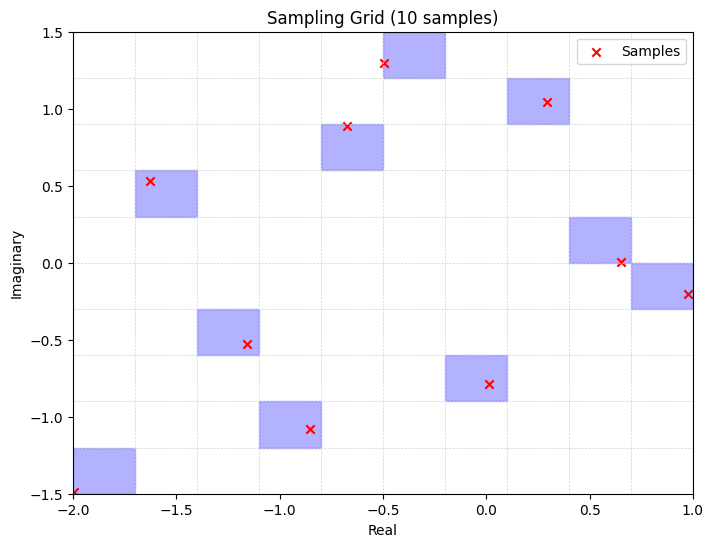

In [36]:
def visualize_samples(complex_range: ComplexRange, samples: np.ndarray[complex]):
    """Visualize samples by marking them and highlighting the box they are part of. Used
    to verify the correctness of LHS and orthogonal sample creation.

    Args:
        complex_range: The range of complex numbers where samples have been drawn from.
        samples: The generated samples to visualize.
    """
    real_values = samples.real
    imag_values = samples.imag

    # Compute the grid boundaries
    real_bounds = np.linspace(complex_range.real_min, complex_range.real_max, samples.shape[0] + 1)
    imag_bounds = np.linspace(
        complex_range.imaginary_min, complex_range.imaginary_max, samples.shape[0] + 1
    )

    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # Draw grid lines
    for i in range(samples.shape[0] + 1):
        plt.axvline(x=real_bounds[i], color="lightgray", linestyle="--", linewidth=0.5)
        plt.axhline(y=imag_bounds[i], color="lightgray", linestyle="--", linewidth=0.5)

    # Highlight squares containing samples
    for real_value, imag_value in zip(real_values, imag_values):
        # Find the indices of the grid cell containing the sample
        i = np.searchsorted(real_bounds, real_value, side="right") - 1
        j = np.searchsorted(imag_bounds, imag_value, side="right") - 1
        # Create a rectangle patch for the grid cell
        rect = patches.Rectangle(
            (real_bounds[i], imag_bounds[j]),
            real_bounds[i + 1] - real_bounds[i],
            imag_bounds[j + 1] - imag_bounds[j],
            color="blue",
            alpha=0.3,
        )
        ax.add_patch(rect)

    # Plot samples as red crosses
    plt.scatter(real_values, imag_values, color="red", marker="x", label="Samples")
    plt.xlim(complex_range.real_min, complex_range.real_max)
    plt.ylim(complex_range.imaginary_min, complex_range.imaginary_max)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.title(f"Sampling Grid ({samples.shape[0]} samples)")
    plt.legend()
    plt.show()


complex_range_lhs = ComplexRange()
visualize_samples_lhs = lhs_samples(complex_range_lhs, 10)

print("Generated LHS samples:")
print(visualize_samples_lhs)

visualize_samples(complex_range_lhs, visualize_samples_lhs)

In [ ]:
def mandelbrot_area_LHS(
    complex_range: ComplexRange,
    num_samples: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using LHS samples. This function is identical to
    mandelbrot_area_RS besides the sample generation.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_samples: The list of number of samples for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(num_samples), len(num_iterations), runs))

    for sample_idx, num_sample in enumerate(tqdm.tqdm(num_samples, desc="Sample Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                complex_values = lhs_samples(complex_range, num_sample)

                domain_area = complex_range.domain_area()

                areas[sample_idx, it_idx, run] = mandelbrot_area(
                    complex_values, num_iteration, domain_area
                )

    return areas


samples_range_lhs = np.linspace(
    STANDARD_NUM_SAMPLES_MIN, STANDARD_NUM_SAMPLES_MAX, num=STANDARD_NUM_SAMPLES_STEPS, dtype=int
)
iterations_range_lhs = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_lhs = mandelbrot_area_LHS(ComplexRange(), samples_range_lhs, iterations_range_lhs)

Sample Range Progress: 100%|██████████| 25/25 [02:43<00:00,  6.53s/it]


The mean area of the Mandelbrot set when calculated with 5000 LHS samples
when iterated 1000 times is 1.522512.


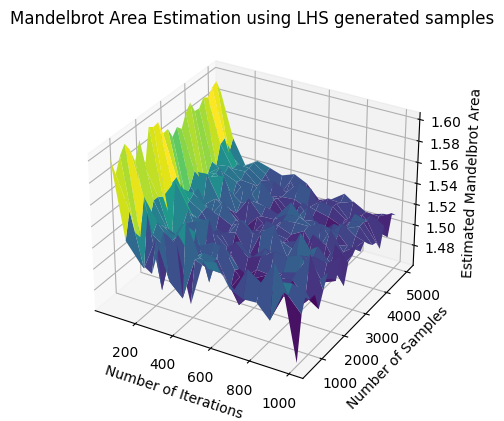

In [39]:
print(
    f"The mean area of the Mandelbrot set when calculated with {samples_range_lhs[-1]} LHS samples\n"
    f"when iterated {iterations_range_lhs[-1]} times is {np.mean(areas_lhs[-1])}."
)

plot_title_lhs = "Mandelbrot Area Estimation using LHS generated samples"
plot_area_3d(areas_lhs, samples_range_lhs, iterations_range_lhs, plot_title_lhs)

### Orthogonal Sampling

In [ ]:
# This function could still use some refactoring
def orthogonal_samples(complex_range: ComplexRange, grid_size: int) -> np.ndarray[complex]:
    num_samples = grid_size**2
    real_scale = (complex_range.real_max - complex_range.real_min) / num_samples
    imaginary_scale = (complex_range.imaginary_max - complex_range.imaginary_min) / num_samples

    xlist = np.arange(num_samples, dtype=int).reshape(grid_size, grid_size)
    ylist = np.arange(num_samples, dtype=int).reshape(grid_size, grid_size)

    for i in range(grid_size):
        np.random.shuffle(xlist[i])
        np.random.shuffle(ylist[i])

    samples = np.empty((grid_size, grid_size), dtype=np.complex_)
    for i in range(grid_size):
        for j in range(grid_size):
            x = complex_range.real_min + real_scale * (xlist[i][j] + np.random.uniform(0, 1))
            y = complex_range.imaginary_min + imaginary_scale * (
                ylist[j][i] + np.random.uniform(0, 1)
            )
            samples[i, j] = x + 1j * y

    return samples

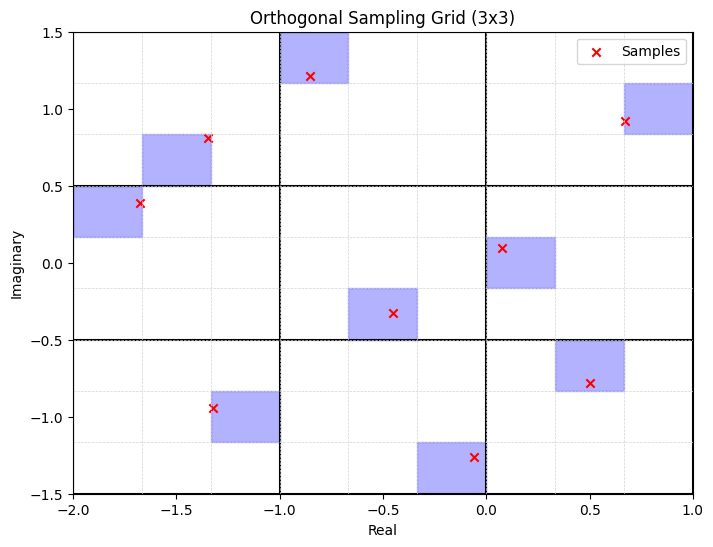

In [42]:
# This function could still use some refactoring
def plot_orthogonal_sampling(complex_range: ComplexRange, grid_size):
    samples = orthogonal_samples(complex_range, grid_size)
    num_samples = grid_size**2

    # Plot the grid and samples
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    real_bounds = np.linspace(complex_range.real_min, complex_range.real_max, grid_size + 1)
    imag_bounds = np.linspace(
        complex_range.imaginary_min, complex_range.imaginary_max, grid_size + 1
    )

    # Add thick black grid lines
    for i in range(grid_size + 1):
        plt.axvline(x=real_bounds[i], color="black", linestyle="-", linewidth=1.5)
        plt.axhline(y=imag_bounds[i], color="black", linestyle="-", linewidth=1.5)

    # Add light gray sub-grid lines
    num_subdivisions = grid_size  # For sub-grid lines
    real_range = np.zeros(num_samples + 1)
    real_range[0] = complex_range.real_min
    real_range[-1] = complex_range.real_max
    imaginary_range = np.zeros(num_samples + 1)
    imaginary_range[0] = complex_range.imaginary_min
    imaginary_range[-1] = complex_range.imaginary_max

    for i in range(grid_size * num_subdivisions + 1):
        real_subdiv = complex_range.real_min + (
            complex_range.real_max - complex_range.real_min
        ) * i / (grid_size * num_subdivisions)
        imag_subdiv = complex_range.imaginary_min + (
            complex_range.imaginary_max - complex_range.imaginary_min
        ) * i / (grid_size * num_subdivisions)
        plt.axvline(x=real_subdiv, color="lightgray", linestyle="--", linewidth=0.5)
        plt.axhline(y=imag_subdiv, color="lightgray", linestyle="--", linewidth=0.5)

        if i > 0 or i < num_samples:
            real_range[i] = real_subdiv
            imaginary_range[i] = imag_subdiv

    # Plot samples as crosses
    real_values = samples.real.flatten()
    imag_values = samples.imag.flatten()

    for r, im in zip(real_values, imag_values):
        i = np.searchsorted(real_range, r) - 1
        j = np.searchsorted(imaginary_range, im) - 1
        rect = patches.Rectangle(
            (real_range[i], imaginary_range[j]),
            real_range[i + 1] - real_range[i],
            imaginary_range[j + 1] - imaginary_range[j],
            color="blue",
            alpha=0.3,
        )
        ax.add_patch(rect)

    plt.scatter(real_values, imag_values, color="red", marker="x", label="Samples")

    plt.xlim(complex_range.real_min, complex_range.real_max)
    plt.ylim(complex_range.imaginary_min, complex_range.imaginary_max)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.title(f"Orthogonal Sampling Grid ({grid_size}x{grid_size})")
    plt.legend()
    plt.show()


plot_orthogonal_sampling(ComplexRange(), 3)

In [43]:
def mandelbrot_area_ORTH(
    complex_range: ComplexRange,
    grid_sizes: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using orthogonal samples. This function is identical to
    mandelbrot_area_RS besides the sample generation and the domain_area used.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        grid_sizes: The list of grid sizes for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(grid_sizes), len(num_iterations), runs))

    for grid_size_idx, grid_size in enumerate(tqdm.tqdm(grid_sizes, desc="Grid Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                complex_values = orthogonal_samples(complex_range, grid_size)

                domain_area = complex_range.domain_area()
                scaled__area = domain_area / grid_size

                areas[grid_size_idx, it_idx, run] = mandelbrot_area(
                    complex_values, num_iteration, scaled__area
                )

    return areas

# Square root of default values as the amount of samples is the grid size squared 
grid_sizes_range_orth = np.linspace(
    int(np.sqrt(STANDARD_NUM_SAMPLES_MIN)),
    int(np.sqrt(STANDARD_NUM_SAMPLES_MAX)),
    num=STANDARD_NUM_SAMPLES_STEPS,
    dtype=int,
)
iterations_range_orth = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_orth = mandelbrot_area_ORTH(
    ComplexRange(), grid_sizes_range_orth, iterations_range_orth
)

Grid Range Progress: 100%|██████████| 25/25 [06:11<00:00, 14.84s/it]


The mean area of the Mandelbrot set when calculated with 4900 orthogonal samples
when iterated 1000 times is 1.52184.


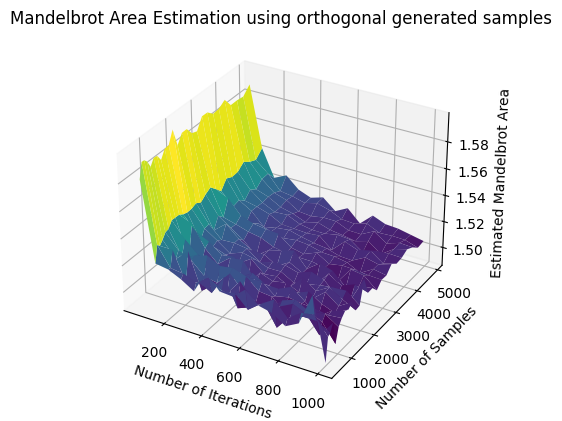

In [44]:
# print(
#     f"The mean area of the Mandelbrot set when calculated with {grid_sizes_range_orth[-1]**2} orthogonal samples\n"
#     f"when iterated {iterations_range_orth[-1]} times is {np.mean(areas_orth[-1])}."
# )

plot_title_orth = "Mandelbrot Area Estimation using orthogonal generated samples"
plot_area_3d(areas_orth, grid_sizes_range_orth**2, iterations_range_orth, plot_title_orth)


### Statistical Analysis of Results

In [ ]:
def confidence_interval(
    areas: np.ndarray[float], p_val: float = 0.95, axis: int = 2
) -> tuple[np.ndarray[float]]:
    """Calculate the confidence interval of an area simulation over a given axis.

    Args:
        areas: Array that contains the area calculations.
        p_val: p-value for which the confidence interval will be calculated.
        axis: Axis of the areas array over which the variance will be calculated.

    Returns:
        Tuple containing the arrays of the mean values, lower and upper bounds.
    """

    mean_areas = np.mean(areas, axis=axis)
    area_variances = np.var(areas, axis=axis)

    # Calculate margin of error
    margin = (norm.ppf((p_val + 1) / 2) * np.sqrt(area_variances)) / np.sqrt(areas.shape[axis])

    lower_bound = mean_areas - margin
    upper_bound = mean_areas + margin

    return (mean_areas, lower_bound, upper_bound)

### Analysis plots

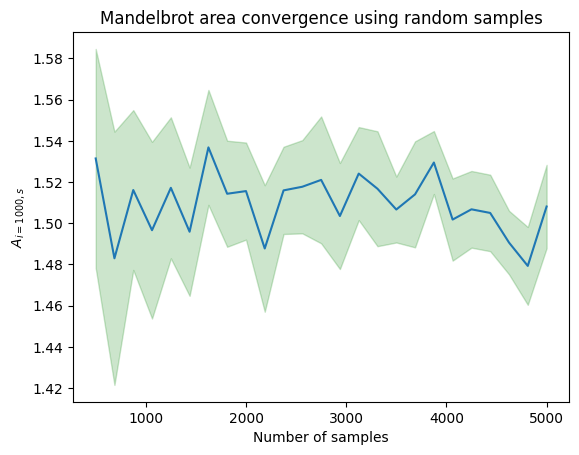

In [62]:
mean_areas_rs, areas_lowerbound_rs, areas_upperbound_rs = confidence_interval(areas_rs[:, -1, :], axis=1)
plt.plot(samples_range_rs, mean_areas_rs)
plt.title("Mandelbrot area convergence using random samples")
plt.xlabel("Number of samples")
plt.fill_between(samples_range_rs, areas_lowerbound_rs, areas_upperbound_rs, alpha=0.2, color="green")
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_rs[-1])
plt.show()

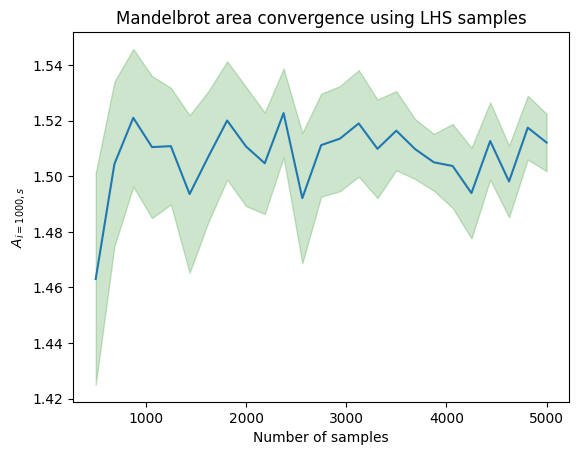

In [61]:
mean_areas_lhs, areas_lowerbound_lhs, areas_upperbound_lhs = confidence_interval(areas_lhs[:, -1, :], axis=1)
plt.title("Mandelbrot area convergence using LHS samples")
plt.plot(samples_range_lhs, mean_areas_lhs)
plt.xlabel("Number of samples")
plt.fill_between(samples_range_lhs, areas_lowerbound_lhs, areas_upperbound_lhs, alpha=0.2, color="green")
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_lhs[-1])
plt.show()

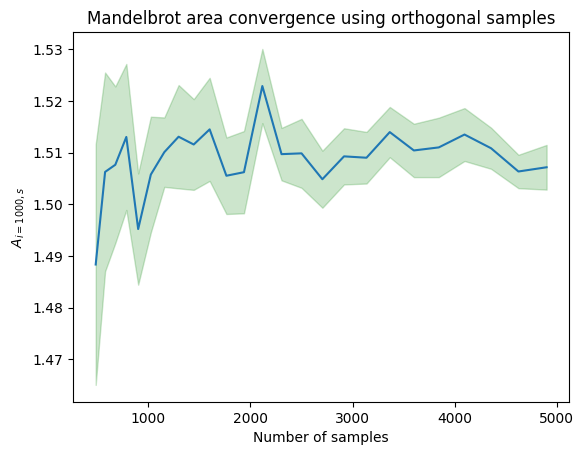

In [60]:
mean_areas_orth, areas_lowerbound_orth, areas_upperbound_orth = confidence_interval(areas_orth[:, -1, :], axis=1)
plt.title("Mandelbrot area convergence using orthogonal samples")
plt.plot(grid_sizes_range_orth**2, mean_areas_orth)
plt.xlabel("Number of samples")
plt.fill_between(grid_sizes_range_orth**2, areas_lowerbound_orth, areas_upperbound_orth, alpha=0.2, color="green")
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_orth[-1])
plt.show()

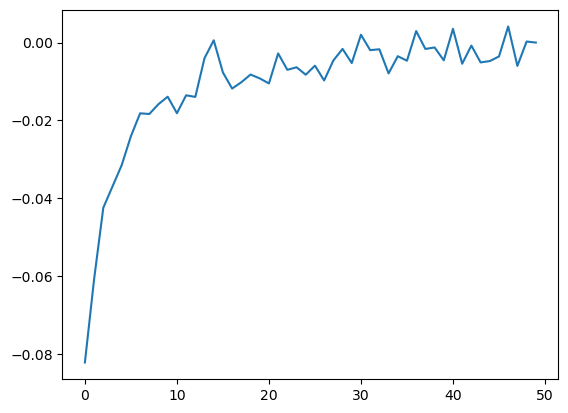

In [ ]:
def analyze_iterations_error(results):
    """
    Analyze the error introduced by low iteration count, compared to the baseline of a high iteration calculation
    """
    mean_runs = np.mean(results[:, :, :], axis=2)
    highest_sample_size = mean_runs[:, -1]
    iteration_error = highest_sample_size[-1] - highest_sample_size
    plt.plot(iteration_error)
    plt.show()


results_mc = np.load("MC.npy")

num_iterations = np.linspace(50, 500, num=50, dtype=int).astype(int)
num_samples = np.linspace(100, 1000, num=50, dtype=int).astype(int)

analyze_iterations_error(results_mc)

## Using antithetic variables? Can you go over this

In [ ]:
results_mc_V2 = np.zeros((len(num_iterations), len(num_samples), STANDARD_NUM_RUNS))
for it_idx, iteration in enumerate(tqdm.tqdm(num_iterations, desc="Iterations Progress")):
    for sample_idx, sample_size in enumerate(num_samples):
        for run in range(STANDARD_NUM_RUNS):

            u = np.random.uniform(size=sample_size)
            v = np.random.uniform(size=sample_size)

            real_parts = STANDARD_REAL_MIN + (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * u
            imag_parts = (
                STANDARD_IMAGINARY_MIN + (STANDARD_IMAGINARY_MAX - STANDARD_IMAGINARY_MIN) * v
            )
            complex_values = real_parts + 1j * imag_parts

            real_parts_anti = STANDARD_REAL_MIN + (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (1 - u)
            imag_parts_anti = STANDARD_IMAGINARY_MIN + (
                STANDARD_IMAGINARY_MAX - STANDARD_IMAGINARY_MIN
            ) * (1 - v)
            complex_values_anti = real_parts_anti + 1j * imag_parts_anti

            domain_area = (STANDARD_REAL_MAX - STANDARD_REAL_MIN) * (
                STANDARD_IMAGINARY_MAX - STANDARD_IMAGINARY_MIN
            )

            area_original = mandelbrot_area(complex_values, iteration, domain_area)
            area_antithetic = mandelbrot_area(complex_values_anti, iteration, domain_area)

            results_mc_V2[it_idx, sample_idx, run] = (area_original + area_antithetic) / 2

Iterations Progress: 100%|██████████| 50/50 [2:00:03<00:00, 144.07s/it]


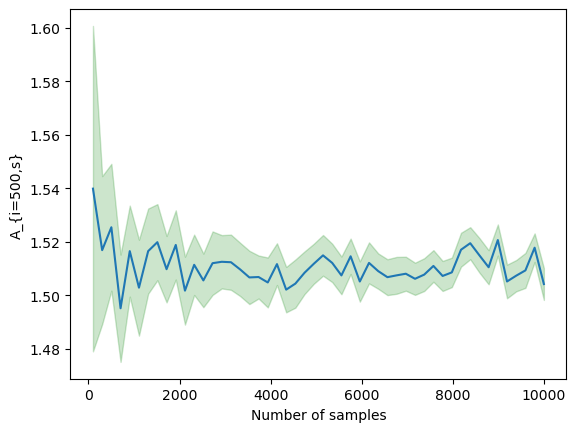

In [ ]:
mean_mc_anti, lowerbound_mc_anti, upperbound_mc_anti = confidence_interval(
    results_mc_V2[-1, :, :], axis=1
)
plt.plot(num_samples, mean_mc_anti)
plt.xlabel("Number of samples")
plt.fill_between(num_samples, lowerbound_mc_anti, upperbound_mc_anti, alpha=0.2, color="green")
plt.ylabel(r"A_{i=500,s}")
plt.show()

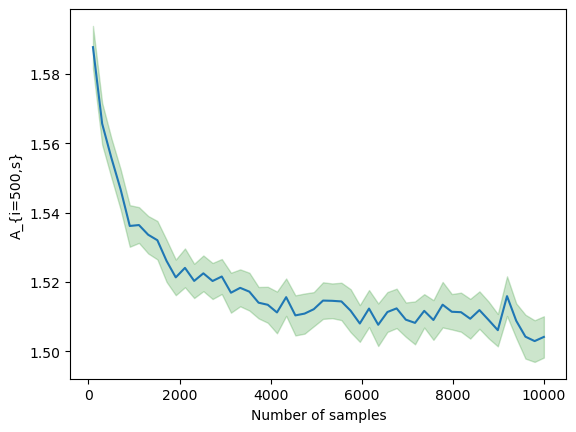

In [ ]:
mean_mc_anti_2, lowerbound_mc_anti_2, upperbound_mc_anti_2 = confidence_interval(
    results_mc_V2[:, -1, :], axis=1
)
plt.plot(num_samples, mean_mc_anti_2)
plt.xlabel("Number of samples")
plt.fill_between(num_samples, lowerbound_mc_anti_2, upperbound_mc_anti_2, alpha=0.2, color="green")
plt.ylabel(r"A_{i=500,s}")
plt.show()

In [ ]:
print((upperbound_mc[-1] - lowerbound_mc[-1]) / 2)
print((upperbound_mc_2[-1] - lowerbound_mc_2[-1]) / 2)
print((upperbound_mc_anti[-1] - lowerbound_mc_anti[-1]) / 2)
print((upperbound_mc_anti_2[-1] - lowerbound_mc_anti_2[-1]) / 2)  # only a small reduction, why?

0.006877361928137704
0.006877361928137704
0.0059552179889990065
0.0059552179889990065


In [65]:
np.save("Antithetic_MC.npy", results_mc_V2)
test_anti = np.load("Antithetic_MC.npy")

In [ ]:
mean_mc_anti_test, lowerbound_mc_anti_test, upperbound_mc_anti_test = confidence_interval(
    test_anti[-1, :, :], axis=1
)
mean_mc_anti_test2, lowerbound_mc_anti_test2, upperbound_mc_anti_test2 = confidence_interval(
    test_anti[:, -1, :], axis=1
)

print((upperbound_mc_anti_test[-1] - lowerbound_mc_anti_test[-1]) / 2)
print((upperbound_mc_anti_test2[-1] - lowerbound_mc_anti_test2[-1]) / 2)
print((upperbound_mc_anti[-1] - lowerbound_mc_anti[-1]) / 2)
print((upperbound_mc_anti_2[-1] - lowerbound_mc_anti_2[-1]) / 2)  # only a small reduction, why?

0.0059552179889990065
0.0059552179889990065
0.0059552179889990065
0.0059552179889990065


### This looks like the "macro"structure of the mandelbrot set, showing self-similarity.

Computing Mandelbrot: 100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


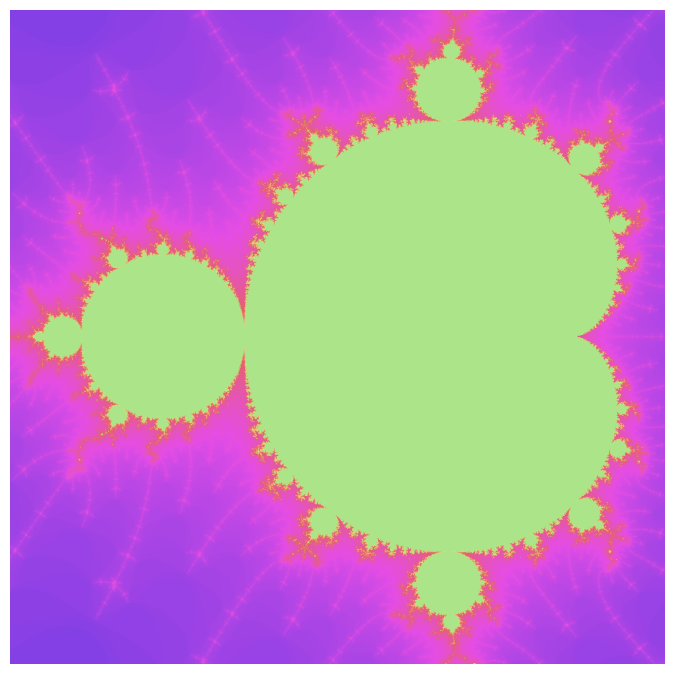

In [93]:
MiniPlot = ComplexRange()
MiniPlot.real_min = -1.6313
MiniPlot.real_max = -1.6233
MiniPlot.imaginary_min = -0.004
MiniPlot.imaginary_max = 0.004
plot_mandelbrot_fractal(MiniPlot, 1000, 850)

Computing Mandelbrot: 100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


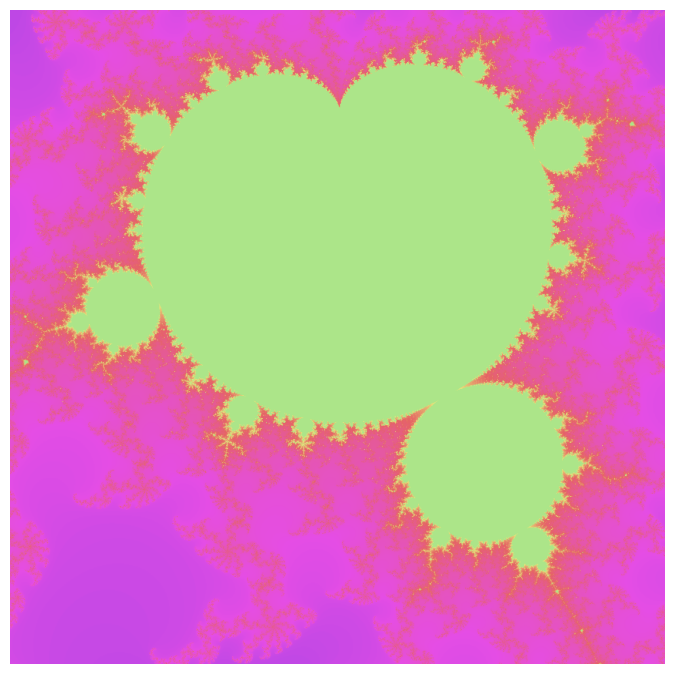

In [121]:
MiniPlot = ComplexRange()
MiniPlot.real_min = 0.3775
MiniPlot.real_max = 0.3796
MiniPlot.imaginary_min = 0.0980
MiniPlot.imaginary_max = 0.1001
plot_mandelbrot_fractal(MiniPlot, 1000, 850)